<a href="https://colab.research.google.com/github/mavikulov/Diploma/blob/main/ConvNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
! wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2025-01-14 07:39:35--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2025-01-14 07:39:35 (28.1 MB/s) - ‘tiny_img.py’ saved [813/813]

--2025-01-14 07:39:35--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response

In [26]:
import matplotlib.pyplot as plt

In [2]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


In [13]:
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cpu'


In [14]:
train_transforms = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     transforms.ColorJitter(brightness=0.9, contrast=0.7, saturation=0.8, hue=0.2)
    ]
)

In [16]:
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_transforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


In [18]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
  def __init__(self, root, transform=transforms.ToTensor):
      super().__init__()

      self.root = root
      with open(os.path.join(root, 'val_annotations.txt')) as f:
        annotations = []
        for line in f:
          img_name, class_label = line.split('\t')[:2]
          annotations.append((img_name, class_label))

      # 1. define self.classes - list of sorted class labels from annotations
      # it should look like self.classes from "TinyImagenetRAM"
      # YOUR CODE
      self.classes = sorted(set(i[1] for i in annotations))

      assert len(self.classes) == 200, len(self.classes)
      assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
      assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

      # 2. self.class_to_idx - dict from class label to class index
      self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

      self.transform = transform

      self.images, self.targets = [], []
      for img_name, class_name in tqdm.tqdm(annotations, desc=root):
        img_name = os.path.join(root, 'images', img_name)
        # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
        # store the class index in self.targets
        # YOUR CODE
        image = tiny_img_dataset.read_rgb_image(img_name)

        assert image.shape == (64, 64, 3), image.shape
        self.images.append(Image.fromarray(image))
        self.targets.append(self.class_to_idx[class_name])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = self.images[index]
    image = self.transform(image)
    target = self.targets[index]
    return image, target

In [19]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:20<00:00, 478.27it/s]


In [20]:
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=2)

In [21]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# ConvNeXt architecture

In [23]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np

torch.Size([3, 64, 64])
tensor(37)


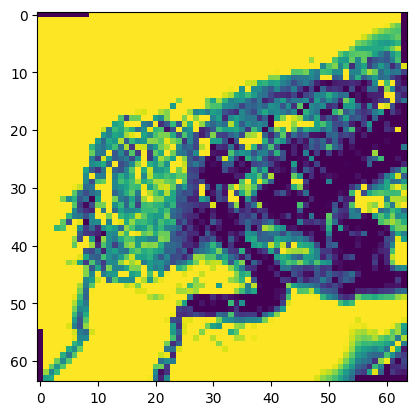

In [32]:
images, labels = train_batch_gen.__iter__().__next__()
print(images[0].shape)
print(labels[0])
plt.imshow(images[0][0])

In [35]:
n_input_channels = 96
n_output_channels = 192
layer = nn.Conv2d(n_input_channels, n_output_channels, kernel_size=(7, 7), groups=n_input_channels)

parameters_size = sum([elem.size().numel() for elem in layer.parameters()])
assert parameters_size == (7*7*192 + 192), parameters_size

In [45]:
class LayerNorm2d(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.ln = nn.LayerNorm(dim)

  def forward(self, x):
    print(x.shape)
    x = x.permute(0, 2, 3, 1)
    x = self.ln(x)
    x = x.permute(0, 3, 1, 2)
    return x

In [47]:
x = torch.rand((2, 5, 4, 3))
layer = LayerNorm2d(5)
out = layer(x)
assert out.size() == x.size()
parameters_size = sum([elem.size().numel() for elem in layer.parameters()])
assert parameters_size == 10, parameters_size  # 5 for channel weights and 5 for biases

torch.Size([2, 5, 4, 3])


In [53]:
class LayerScale2d(nn.Module):
  def __init__(self, dim, layer_scale_init_value):
    super().__init__()
    self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim, 1, 1)), requires_grad=True)

  def forward(self, x):
    x = x * self.gamma
    return x

In [54]:
x = torch.rand((2, 5, 4, 3))
layer_scale_init_value = 1e-5
layer = LayerScale2d(5, layer_scale_init_value)
out = layer(x)
assert out.size() == x.size()
assert np.allclose(out.detach().numpy(), x.numpy()*layer_scale_init_value)

In [56]:
class DropPath(nn.Module):
  def __init__(self, drop_prob=None):
    super(DropPath, self).__init__()
    self.drop_prob = drop_prob

  def forward(self, x):
    if self.drop_prob == 0. or not self.training:
      return x
    keep_prob = 1 - self.drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = torch.rand(shape, device=x.device)
    binary_tensor = (random_tensor < keep_prob).to(x.dtype)
    out = x * binary_tensor / keep_prob
    return out

In [57]:
layer = DropPath(0.5)

x = torch.rand((10,5,4,3))

layer.eval()
out = layer(x)
assert out.size() == x.size()
assert (out == x).all()

layer.train()
out = layer(x)
assert out.size() == x.size()
dropped_samples_mask = torch.isclose(out, torch.zeros([1])).all(dim=(1,2,3))
n_dropped_samples = dropped_samples_mask.to(float).sum()
assert n_dropped_samples > 2 and n_dropped_samples < 8, n_dropped_samples

layer = DropPath(0.1)
out = layer(x)
dropped_samples_mask = torch.isclose(out, torch.zeros([1])).all(dim=(1,2,3))
scaled_samples_mask = torch.isclose(out, x/0.9).all(dim=(1,2,3))
assert torch.logical_or(dropped_samples_mask, scaled_samples_mask).all()

In [59]:
class ConvNextBlock(nn.Module):
    def __init__(self, dim, drop_rate=0., layer_scale_init_value=1e-6, use_bn=False):
        super().__init__()

        # YOUR CODE: define self.depthwise_conv  self.pointwise_conv1 self.pointwise_conv2
        self.depthwise_conv = nn.Conv2d(
            in_channels=dim,
            out_channels=dim,
            kernel_size=(5, 5),
            padding=2,
            groups=dim
        )  # depthwise conv 5x5, padding 2, dim->dim

        self.norm = LayerNorm2d(dim) if not use_bn else nn.BatchNorm2d(dim)

        self.pointwise_conv1 = nn.Conv2d(
            in_channels=dim,
            out_channels=dim * 4,
            kernel_size=(1, 1)
        )  # 1x1 conv, dim -> dim*4  YOUR CODE

        self.activation = nn.GELU()

        self.pointwise_conv2 = nn.Conv2d(
            in_channels=dim * 4,
            out_channels=dim,
            kernel_size=(1, 1)
        )  # 1x1 conv, 4*dim -> dim YOUR CODE

        self.layer_scale = LayerScale2d(dim, layer_scale_init_value) if layer_scale_init_value > 0 else nn.Identity()
        self.drop_path = DropPath(drop_rate) if drop_rate is not None and drop_rate > 0. else nn.Identity()

    def forward(self, x):
        input = x
        # YOUR CODE: sequentially apply to x: depthwise_conv + norm + pointwise_conv1 + activation + pointwise_conv2 + layer_scale
        x = self.depthwise_conv(x)
        x = self.norm(x)
        x = self.pointwise_conv1(x)
        x = self.activation(x)
        x = self.pointwise_conv2(x)
        x = self.layer_scale(x)

        x = input + self.drop_path(x)
        return x

In [60]:
block_w_ln = ConvNextBlock(7, 0.1, 1e-6, use_bn=False)

x = torch.rand([2,7,4,3])
out = block_w_ln(x)

assert out.size() == x.size()
n_dwconv_parameters = sum([elem.size().numel() for elem in block_w_ln.depthwise_conv.parameters()])
assert n_dwconv_parameters == 5*5*7 + 7
n_pwconv1_parameters = sum([elem.size().numel() for elem in block_w_ln.pointwise_conv1.parameters()])
assert n_pwconv1_parameters == 7*7*4 + 7*4
n_pwconv2_parameters = sum([elem.size().numel() for elem in block_w_ln.pointwise_conv2.parameters()])
assert n_pwconv2_parameters == 7*7*4 + 7

torch.Size([2, 7, 4, 3])


In [61]:
block_w_bn = ConvNextBlock(7, 0.1, 1e-6, use_bn=True)

x = torch.rand([2,7,4,3])
out = block_w_bn(x)
assert out.size() == x.size()

n_block1_parameters = sum([elem.size().numel() for elem in block_w_ln.parameters()])
n_block2_parameters = sum([elem.size().numel() for elem in block_w_bn.parameters()])
assert n_block1_parameters == n_block2_parameters

In [63]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.mean(x, dim=self.dim)

In [64]:
def create_stem(out_channels, use_bn):
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=(2, 2), stride=2, padding=0), # YOUR CODE; conv 2x2, stride 2, padding 0
        nn.BatchNorm2d(out_channels) if use_bn else LayerNorm2d(out_channels)
    )

def create_downscale_block(in_channels, out_channels, use_bn):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels) if use_bn else LayerNorm2d(in_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=(2, 2), stride=2)  # YOUR CODE: conv 2x2, stride 2, padding 0
    )

In [65]:
def create_convnext_like_network(config=None, use_bn=False, drop_rate=None):
    """
    Creates ConvNeXt like network according to config
    """
    model = nn.Sequential()

    default_config = [[32, 32], [64, 64], [128, 128]]
    config = config or default_config

    stem_out_channels = config[0][0]
    # YOUR CODE: create stem
    model.add_module('stem', create_stem(stem_out_channels, use_bn))

    # progressivily increase drop rate from 0 to 'drop_rate'
    drop_rates = np.linspace(0, drop_rate, sum([len(e) for e in config])) if drop_rate is not None else None

    layer_index = 0
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            layer_drop_rate = drop_rates[layer_index] if drop_rates is not None else None

            # YOUR CODE: add ConvNextBlock
            model.add_module(f"{block_index}_{layer_index_in_block}", ConvNextBlock(out_channels, layer_drop_rate, ))
            layer_index += 1

        if block_index != len(config) - 1:
            downscale_in_channels = out_channels
            downscale_out_channels = config[block_index+1][0]
            # YOUR CODE: add downscale block
            model.add_module(f'downscale_{block_index}', create_downscale_block(downscale_in_channels, downscale_out_channels, use_bn))

    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('norm_final', nn.BatchNorm1d(out_channels) if use_bn else nn.LayerNorm(out_channels))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

# Training technics

In [66]:
def compute_loss(predictions, gt, label_smoothing=0.0):
    return F.cross_entropy(predictions, gt, label_smoothing=label_smoothing).mean()

In [67]:
def create_averaged_model(model, decay=0.999):
    # YOUR CODE: create AveragedModel instance with ema multi_avg_fn (dont forget to use 'decay' parameter)
    averaged_model = torch.optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(decay))

    return averaged_model

In [68]:
import numpy as np
import time
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator, ema_model=None, label_smoothing=0.0):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch,
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)

        loss = compute_loss(predictions, y_batch, label_smoothing)

        # backward
        loss.backward()
        optimizer.step()

        if ema_model is not None:
            # YOUR CODE: update parameters of ema model here (see pytorch doc on AveragedModel)
            ema_model.update_parameters(model)

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def get_input_for_bn_recompute(data_generator):
    for i, (x, y) in enumerate(data_generator):
        x = x.to(device)
        yield x
        if i == 100:
            break


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs, ema_model=None, label_smoothing=0.0):
    """
    num_epochs - total amount of full passes over training data
    """
    train_metrics = defaultdict(list)
    val_metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator, ema_model, label_smoothing)

        if ema_model is not None:
            # YOUR CODE: update batchnorm statistics for ema_model (see pytorch doc on AveragedModel)
            torch.optim.swa_utils.update_bn(get_input_for_bn_recompute(train_data_generator), ema_model) # you may need get_input_for_bn_recompute() function here

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))
        train_metrics['loss'].append(train_loss)
        val_metrics['accuracy'].append(val_accuracy)

        if ema_model:
            print("  validation accuracy(ema): \t\t\t{:.2f} %".format(val_accuracy_ema_model * 100))
            val_metrics['ema_model_accuracy'].append(val_accuracy_ema_model)

    print('Best model accuracy: ', max(val_metrics['accuracy']))
    if ema_model:
        print('Best ema model accuracy: ', max(val_metrics['ema_model_accuracy']))

    plt.plot(val_metrics['accuracy'], label='model')
    if ema_model:
        plt.plot(val_metrics['ema_model_accuracy'], label='ema_model')
    plt.grid()
    plt.legend(loc='best')
    return train_metrics, val_metrics